In [1]:
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # ignoring the duplicate libraries

import cv2
import shutil
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import clear_output
from warnings import filterwarnings
filterwarnings("ignore")

from GoogleNet import *
from torchmetrics import Accuracy

# Loading & Splitting Dataset 

In [93]:
def load_cifar_data():

    load_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((96,96)),
    transforms.Normalize(mean = [0.5], std = [0.5]) 
    ])
    dataset_file = './data'
    download_flag = True
    # if os.path.exists(dataset_file):
    #     download_flag = False 
    # else:
    #     download_flag = True

    train_dataset = datasets.CIFAR10(dataset_file, train=True, download=download_flag, transform=load_transforms)
    test_dataset = datasets.CIFAR10(dataset_file, train=False, download=download_flag, transform=load_transforms) 

    clear_output() # clear downloading progress 

    train_dataset, val_dataset = random_split(train_dataset, (45000,5000))
    classes = train_dataset.dataset.classes
    

    print(f"Image shape: {train_dataset[0][0].numpy().shape}")
    print(f"Training set: {len(train_dataset)}")
    print(f"validation set: {len(val_dataset)}")
    print(f"Test set: {len(test_dataset)}")
    print(f"Classes: {classes}")

    
    BATCH_SIZE = 16
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

    shutil.rmtree("./data") # remove the data dir


    return  train_loader, val_loader, test_loader


In [31]:
train_loader, val_loader, test_loader =  load_cifar_data()

Image shape: (3, 96, 96)
Training set: 45000
validation set: 5000
Test set: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [65]:
mini_batch_image, labels = next(iter(train_loader))
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f"mini-batch shape: {mini_batch_image.shape}") 

mini-batch shape: torch.Size([16, 3, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


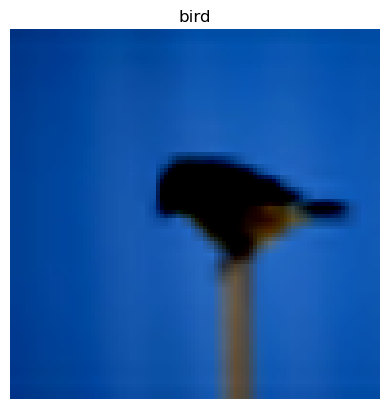

In [73]:
idx = np.random.randint(0,15) 
sample_image = mini_batch_image[idx].permute(1,2,0)
plt.imshow(sample_image)
plt.title(classes[labels[idx].item()]) 
plt.axis("off");

# Initializing & Training the Model 

In [40]:
model = GoogleNet(10)


In [41]:
device = torch.device("cuda")
model.to(device)
summary(model, (3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 64, 48, 48]          --
|    └─Conv2d: 2-1                       [-1, 64, 48, 48]          9,472
|    └─BatchNorm2d: 2-2                  [-1, 64, 48, 48]          128
|    └─ReLU: 2-3                         [-1, 64, 48, 48]          --
├─MaxPool2d: 1-2                         [-1, 64, 24, 24]          --
├─ConvBlock: 1-3                         [-1, 64, 24, 24]          --
|    └─Conv2d: 2-4                       [-1, 64, 24, 24]          4,160
|    └─BatchNorm2d: 2-5                  [-1, 64, 24, 24]          128
|    └─ReLU: 2-6                         [-1, 64, 24, 24]          --
├─ConvBlock: 1-4                         [-1, 192, 24, 24]         --
|    └─Conv2d: 2-7                       [-1, 192, 24, 24]         110,784
|    └─BatchNorm2d: 2-8                  [-1, 192, 24, 24]         384
|    └─ReLU: 2-9                         [-1, 192, 24, 24]         --
├

Layer (type:depth-idx)                   Output Shape              Param #
├─ConvBlock: 1-1                         [-1, 64, 48, 48]          --
|    └─Conv2d: 2-1                       [-1, 64, 48, 48]          9,472
|    └─BatchNorm2d: 2-2                  [-1, 64, 48, 48]          128
|    └─ReLU: 2-3                         [-1, 64, 48, 48]          --
├─MaxPool2d: 1-2                         [-1, 64, 24, 24]          --
├─ConvBlock: 1-3                         [-1, 64, 24, 24]          --
|    └─Conv2d: 2-4                       [-1, 64, 24, 24]          4,160
|    └─BatchNorm2d: 2-5                  [-1, 64, 24, 24]          128
|    └─ReLU: 2-6                         [-1, 64, 24, 24]          --
├─ConvBlock: 1-4                         [-1, 192, 24, 24]         --
|    └─Conv2d: 2-7                       [-1, 192, 24, 24]         110,784
|    └─BatchNorm2d: 2-8                  [-1, 192, 24, 24]         384
|    └─ReLU: 2-9                         [-1, 192, 24, 24]         --
├

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001) 

In [44]:
save_dir = 'save_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

EPOCHS = 15
BATCH_SIZE = 16
train_cost, val_cost = list(), list()
train_acc, val_acc = list(), list()

# training phase 
for epoch in range(EPOCHS):
    train_loss = 0 
    acc_train = Accuracy(task="multiclass", num_classes=10).to(device)
    model.train().cuda()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions0, predictions1, predictions2 = model(images)

        loss0 = criterion(predictions0, labels)
        loss1 = criterion(predictions1, labels)
        loss2 = criterion(predictions2, labels)

        loss = loss0 + 0.3 * loss1 + 0.3 * loss2
        train_loss += loss.item() 

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(predictions0, 1)
        acc_train(predicted, labels)
        
    train_cost.append(train_loss / len(train_loader))
    train_acc.append(acc_train.compute())


    val_loss = 0 
    acc_val = Accuracy(task="multiclass", num_classes=10).to(device)
    model.eval().cuda()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            predictions0, predictions1, predictions2 = model(images)

            loss0 = criterion(predictions0, labels)
            loss1 = criterion(predictions1, labels)
            loss2 = criterion(predictions2, labels)

            loss = loss0 + 0.3 * loss1 + 0.3 * loss2
            val_loss += loss.item()

            _, predicted = torch.max(predictions0, 1)
            acc_val(predicted, labels)

    val_cost.append( val_loss / len(val_loader))
    val_acc.append(acc_val.compute())

    info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"
    print(info.format(epoch+1, EPOCHS, train_loss, acc_train.compute(), val_loss, acc_val.compute()))
    torch.save(model.state_dict(), 'save_weights/checkpoint_gpu_{}'.format(epoch + 1)) 
                                                                
torch.save(model.state_dict(), 'save_weights/googlenet_weights_gpu') 

[Epoch 1/15]: train-loss = 3383.545071 | train-acc = 0.746 | val-loss = 341.598534 | val-acc = 0.761
[Epoch 2/15]: train-loss = 2950.158599 | train-acc = 0.780 | val-loss = 298.683837 | val-acc = 0.804
[Epoch 3/15]: train-loss = 2625.902137 | train-acc = 0.808 | val-loss = 295.970622 | val-acc = 0.810
[Epoch 4/15]: train-loss = 2339.880903 | train-acc = 0.830 | val-loss = 280.187097 | val-acc = 0.814
[Epoch 5/15]: train-loss = 2065.314383 | train-acc = 0.851 | val-loss = 258.710821 | val-acc = 0.834
[Epoch 6/15]: train-loss = 1829.532988 | train-acc = 0.868 | val-loss = 263.524608 | val-acc = 0.833
[Epoch 7/15]: train-loss = 1607.193481 | train-acc = 0.886 | val-loss = 260.569512 | val-acc = 0.834
[Epoch 8/15]: train-loss = 1431.592999 | train-acc = 0.898 | val-loss = 260.155999 | val-acc = 0.841
[Epoch 9/15]: train-loss = 1260.658206 | train-acc = 0.910 | val-loss = 276.659791 | val-acc = 0.841
[Epoch 10/15]: train-loss = 1100.040875 | train-acc = 0.922 | val-loss = 262.974100 | val-a

The difference in scale for val-loss vs train-loss is due to the difference in dataset size for each, after normalizing it by the number of batches in each.

[tensor(0.7463, device='cuda:0'),
 tensor(0.7802, device='cuda:0'),
 tensor(0.8080, device='cuda:0'),
 tensor(0.8302, device='cuda:0'),
 tensor(0.8508, device='cuda:0'),
 tensor(0.8681, device='cuda:0'),
 tensor(0.8860, device='cuda:0'),
 tensor(0.8982, device='cuda:0'),
 tensor(0.9102, device='cuda:0'),
 tensor(0.9223, device='cuda:0'),
 tensor(0.9310, device='cuda:0'),
 tensor(0.9397, device='cuda:0'),
 tensor(0.9465, device='cuda:0'),
 tensor(0.9498, device='cuda:0'),
 tensor(0.9568, device='cuda:0')]

In [86]:
train_acc_values = [acc.item() for acc in train_acc]
val_acc_values =  [acc.item() for acc in val_acc]

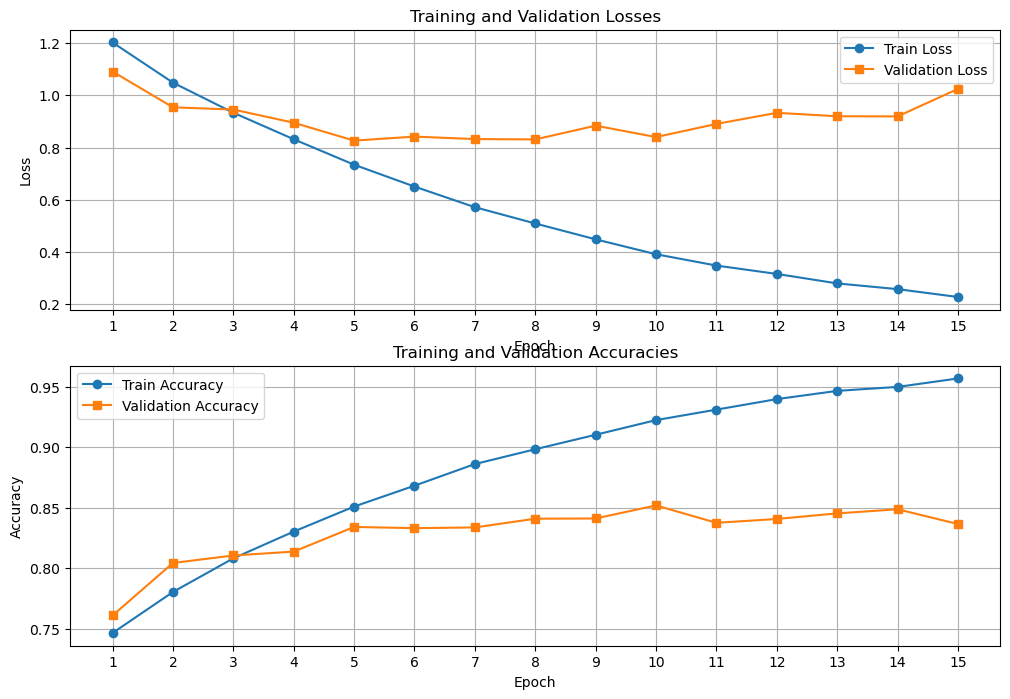

In [87]:
plt.figure(figsize=(12, 8))

# Plotting losses
plt.subplot(2, 1, 1)
plt.plot(range(1, EPOCHS + 1), train_cost, label='Train Loss', marker='o')
plt.plot(range(1, EPOCHS + 1), val_cost, label='Validation Loss', marker='s')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.grid(True)

# Plotting accuracies
plt.subplot(2, 1, 2)
plt.plot(range(1, EPOCHS + 1), train_acc_values, label='Train Accuracy', marker='o')
plt.plot(range(1, EPOCHS + 1), val_acc_values, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, EPOCHS + 1))
plt.legend()
plt.grid(True)

By observing the above plot, we can deduce that the model optimized at the **5th EPOCH** gives the best compromise between loss and accuracy. 

# Evaluating the Model 

In [89]:
model = GoogleNet()
model.load_state_dict(torch.load("save_weights/checkpoint_gpu_5"))

<All keys matched successfully>

In [92]:
acc = Accuracy(task="multiclass", num_classes=10).to(device)

model.eval().cuda()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        predictions, _, _ = model(images) # neglict the auxiliary classifiers 

        _, predicted = torch.max(predictions, 1)

        acc(predicted, labels)


print(f"Test Accuracy: {acc.compute().data:.3f}")

Test Accuracy: 0.828
